# Classification with Logistic Regression



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportion_confint
from sklearn import linear_model
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Part 2

In [3]:
y = df.Outcome
X = df.drop('Outcome', axis = 'columns').astype('float').values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5, random_state = 0)

## Part 3


- Logistic Regression uses a penalty by default. penalty=’l2’ is a default penalty. L2 penalty is equal to the square of the magnitude of coefficients. So, Logistic Regression uses ridge regression by default.

- C is inverse regularization parameter. A control variable that retains strength modification of Regularization by being inversely positioned to the Lambda regulator. The relationship, would be that lowering C would strengthen the Lambda regulator.

- C = 1/λ => C = 1/2 = 0.5

## Part 4

In [4]:
logit_pipe = Pipeline([
    ('logistic_regression', LogisticRegression(solver='newton-cg', 
                                               penalty = 'l2',
                                               max_iter=10000))
])

## Part 5

In [5]:
lr = logit_pipe.fit(Xtrain,ytrain)
ytrain_pred = lr.predict(Xtrain)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    
    tp = sum(np.logical_and(y_pred == 1, y_true == 1))
    tn = sum(np.logical_and(y_pred == 0, y_true == 0))
    fp = sum(np.logical_and(y_pred == 1, y_true == 0))
    fn = sum(np.logical_and(y_pred == 0, y_true == 1))
    
    return ax, tp, tn, fp, fn

Confusion matrix, without normalization


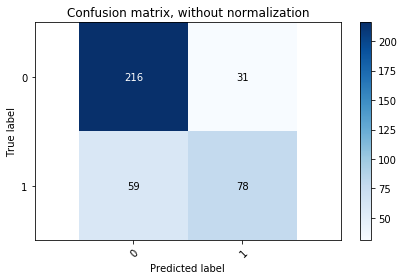

In [7]:
_, tp, tn, fp, fn = plot_confusion_matrix(ytrain, ytrain_pred, np.array([0,1]))

In [8]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) 
recall = tp / (tp + fn)

print("accuracy is:", accuracy)
print("presicion is:", precision)
print("recall is:", recall)

accuracy is: 0.765625
presicion is: 0.7155963302752294
recall is: 0.5693430656934306


## Part 6

In [9]:
cv_score = cross_val_score(logit_pipe, Xtest, ytest, cv=5, scoring='recall')

In [10]:
cv_score_mean = cv_score.mean()
print("Logistic regressions out of sample recall is:", cv_score_mean)

Logistic regressions out of sample recall is: 0.5715099715099715


In [11]:
steps = [('scaler', StandardScaler()), ('logistic_regression', LogisticRegression(solver="newton-cg",
                                                                                  penalty = "l2",
#                                                                                   max_iter=10000
                                                                                  ))]
logit_pipe2 = Pipeline(steps)

In [12]:
points = np.linspace(0.1,100,25)
parameteres = {'logistic_regression__C':points} 
grid = GridSearchCV(logit_pipe2, param_grid=parameteres, cv=5, scoring='recall')
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic_regression__C': array([  0.1   ,   4.2625,   8.425 ,  12.5875,  16.75  ,  20.9125,
        25.075 ,  29.2375,  33.4   ,  37.5625,  41.725 ,  45.8875,
        50.05  ,  54.2125,  58.375 ,  62.5375,  66.7   ,  70.8625,
        75.025 ,  79.1875,  83.35  ,  87.5125,  91.675 ,  95.8375,
       100.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

## Part 7

In [13]:
print(grid.best_params_)
print(grid.best_score_)


{'logistic_regression__C': 4.2625}
0.5474192570546738


## Part 8



In [14]:
print(grid.best_params_)
print("𝜆 is:", 1/grid.best_params_['logistic_regression__C'])

{'logistic_regression__C': 4.2625}
𝜆 is: 0.2346041055718475


- The regularization strength is 0.2346

- This model is not that responsive to regularization. When there are too many features in the dataset which can be used for prediction and we want to decide about the flexibility of the model and controling overfitting, using regularization makes more sense.

# Part 9

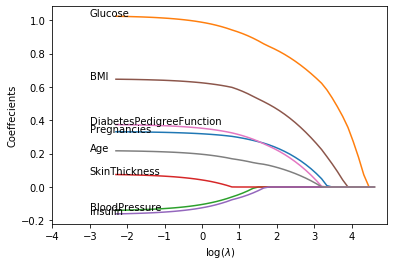

In [16]:
steps = np.logspace(-1, 2, 50)
Coeffecients = np.zeros((steps.size, X.shape[1]))

for i,j in enumerate(steps):
    logit_pipe3 = Pipeline([('scale', StandardScaler()), ('logistic_regression', LogisticRegression(penalty = 'l1',solver='liblinear',C = 1.0/j))])
    
    logit_pipe3.fit(Xtrain, ytrain)
    Coeffecients[i] = logit_pipe3.named_steps['logistic_regression'].coef_

fig, ax = plt.subplots()
ax.plot(np.log(steps), Coeffecients)
ax.set_xlabel(r'$\log(\lambda)$')
ax.set_ylabel(r'Coeffecients')
ax.set_xlim(-4,None)
for i, name in enumerate(df.columns[:-1]):
    
    ax.annotate(name, xy = (-3, Coeffecients[0,i]))

Glucose is the last coefficient reaching zero.